# EDA USA

## Overview
This notebook contains **Exploratory Data Analysis** and **Visualization** for the cases and vaccinations in India.

**Sections:**
1. [Data Ingestion](#Data_Ingestion)
2. [Summary Statistics](#Summary_Statistics)
3. [Data Cleaning](#Data_Cleaning)
4. [Visualization](#Visualization)
5. [Correlation](#Correlation)
6. [Preprocessing](#Preprocessing)
7. [Conclusion](#Conclusion)

***
## Setup

***NOTE***: Please install seaborn version >=  `0.11.0`. You could update your seaborn installation by running `pip install -U seaborn`

In [2]:
import os
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

***
<a id='Data_Ingestion'></a>
## 1. Data Ingestion

### 1.1 Getting daily state-wise cases for USA

In [3]:
cases = pd.read_csv("../raw_datasets/usa_cases_12-10-2021.csv", index_col=0)
cases

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,...,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate,Date,Total_Test_Results,Case_Fatality_Ratio,Cases_28_Days,Deaths_28_Days
0,Alabama,US,2020-04-12 23:18:15,32.3182,-86.9023,3667,93,NaN,3470.0,1.0,...,2.610160,84000001.0,USA,1265.075660,12.264945,2020-04-12,NaN,NaN,NaN,NaN
1,Alaska,US,2020-04-12 23:18:15,61.3707,-152.4044,272,8,66.0,264.0,2.0,...,2.941176,84000002.0,USA,1344.711576,11.397059,2020-04-12,NaN,NaN,NaN,NaN
2,Arizona,US,2020-04-12 23:18:15,33.7298,-111.4312,3542,115,NaN,3427.0,4.0,...,3.246753,84000004.0,USA,578.522286,NaN,2020-04-12,NaN,NaN,NaN,NaN
3,Arkansas,US,2020-04-12 23:18:15,34.9697,-92.3731,1280,27,367.0,1253.0,5.0,...,2.109375,84000005.0,USA,761.753354,10.156250,2020-04-12,NaN,NaN,NaN,NaN
4,California,US,2020-04-12 23:18:15,36.1162,-119.6816,22137,645,NaN,22155.0,6.0,...,2.812020,84000006.0,USA,485.423868,22.961176,2020-04-12,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31855,Virginia,US,2021-10-13 04:31:30,37.7693,-78.1700,895619,13219,NaN,NaN,51.0,...,NaN,84000051.0,USA,111222.504455,NaN,2021-10-12,9493418.0,1.475962,NaN,NaN
31856,Washington,US,2021-10-13 04:31:30,47.4009,-121.4905,686417,8062,NaN,NaN,53.0,...,NaN,84000053.0,USA,129252.544980,NaN,2021-10-12,9842443.0,1.174505,NaN,NaN
31857,West Virginia,US,2021-10-13 04:31:30,38.4912,-80.9545,254648,3995,NaN,NaN,54.0,...,NaN,84000054.0,USA,226668.571272,NaN,2021-10-12,4062234.0,1.568832,NaN,NaN
31858,Wisconsin,US,2021-10-13 04:31:30,44.2685,-89.6165,844102,9101,NaN,NaN,55.0,...,NaN,84000055.0,USA,189778.450043,NaN,2021-10-12,11049725.0,1.078187,NaN,NaN


### 1.2  Getting daily state-wise vaccinations for USA

In [4]:
vacc = pd.read_csv("../raw_datasets/usa_vaccines_12-10-2021.csv", index_col=0)
vacc

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
0,2020-12-20,United States,556208.0,NaN,NaN,NaN,0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-12-21,United States,614117.0,NaN,NaN,NaN,0.18,NaN,NaN,NaN,57909.0,57909.0,174.0,NaN
2,2020-12-22,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127432.0,384.0,NaN
3,2020-12-23,United States,1008025.0,NaN,NaN,NaN,0.30,NaN,NaN,NaN,NaN,150606.0,454.0,NaN
4,2020-12-24,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191001.0,575.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17496,2021-10-12,Virginia,11188615.0,13117025.0,5924366.0,61.57,131.08,5255434.0,69.41,153.68,NaN,23479.0,2751.0,0.853
17497,2021-10-12,Washington,9876205.0,11708255.0,5186876.0,62.13,129.70,4731460.0,68.11,153.75,NaN,21373.0,2807.0,0.844
17498,2021-10-12,West Virginia,1571928.0,3038725.0,869531.0,40.69,87.71,729254.0,48.52,169.56,NaN,1706.0,952.0,0.517
17499,2021-10-12,Wisconsin,6994730.0,7741485.0,3590271.0,57.31,120.13,3336799.0,61.66,132.96,NaN,16533.0,2840.0,0.904


***
<a id='Summary_Statistics'></a>
## 2. Summary Statistics

In [5]:
# Summary statistics for cases in USA
cases.describe()

,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,Testing_Rate,Hospitalization_Rate,Total_Test_Results,Case_Fatality_Ratio,Cases_28_Days,Deaths_28_Days
count,30744.000000,30744.000000,3.186000e+04,31860.000000,1.512200e+04,1.908300e+04,31841.000000,30744.000000,1.181600e+04,5129.000000,12027.000000,3.186000e+04,30740.000000,5129.000000,1.892400e+04,19273.000000,116.000000,116.000000
mean,36.840089,-85.206614,3.487884e+05,6563.056058,8.578908e+04,1.056526e+05,3282.314092,5671.899662,1.110360e+06,6151.226555,3.305093,7.676607e+07,82311.855285,12.143891,7.405400e+06,1.637484,34254.456897,170.336207
std,10.789567,49.309014,5.945479e+05,10668.394849,1.933303e+05,2.789115e+05,17242.983347,4701.584592,2.059909e+06,13791.089316,2.482413,2.357145e+07,78462.835502,5.245396,1.122328e+07,0.656224,61243.435061,264.374962
min,-14.271000,-170.132200,0.000000e+00,0.000000,0.000000e+00,-1.207200e+05,1.000000,0.000000,3.000000e+00,2.000000,0.000000,1.600000e+01,5.391708,1.418440,1.768000e+03,0.000000,0.000000,0.000000
25%,34.594600,-101.165775,2.121200e+04,440.000000,3.872000e+03,3.181500e+03,18.000000,1164.169048,1.121925e+05,558.000000,1.667964,8.400001e+07,18665.073967,8.359942,1.544981e+06,1.276743,3603.250000,21.750000
50%,39.061850,-87.944200,1.212900e+05,2249.000000,1.754850e+04,1.810900e+04,32.000000,4682.972508,4.153255e+05,2014.000000,2.818801,8.400003e+07,63424.241541,11.282093,3.738018e+06,1.589871,17370.500000,102.500000
75%,42.361650,-76.970625,4.438310e+05,7757.000000,8.425575e+04,8.257850e+04,48.000000,9976.682990,1.152972e+06,6001.000000,4.413457,8.400004e+07,123498.541188,15.268243,8.796718e+06,1.904325,38470.750000,188.000000
max,61.370700,145.673900,4.792729e+06,70204.000000,2.470308e+06,3.542626e+06,99999.000000,18399.033324,1.956515e+07,89995.000000,70.370370,8.410000e+07,512404.081328,38.501190,9.619718e+07,6.405536,364090.000000,1538.000000


In [6]:
# Summary statistics for vaccines in USA
vacc.describe()

,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
count,1.684700e+04,1.659400e+04,1.658300e+04,15699.000000,15798.000000,1.650300e+04,15774.000000,15785.000000,1.639100e+04,1.743600e+04,16350.000000,16594.000000
mean,7.800147e+06,9.530912e+06,4.476359e+06,32.717960,72.039767,3.519152e+06,40.996932,89.038975,4.767542e+04,4.643609e+04,4213.233272,0.780076
std,3.414258e+07,4.140351e+07,1.937468e+07,19.587797,38.511172,1.594108e+07,20.163901,43.154350,2.201510e+05,2.068789e+05,2918.643435,0.130476
min,4.160000e+02,6.000000e+03,4.010000e+02,0.000000,0.170000,1.000000e+00,0.240000,6.140000,-4.731910e+05,-5.351900e+04,-16746.000000,0.043000
25%,5.695970e+05,7.557488e+05,3.513800e+05,14.690000,39.032500,1.836855e+05,24.862500,52.980000,1.703500e+03,3.051500e+03,2033.000000,0.738000
50%,1.890198e+06,2.371975e+06,1.113514e+06,35.390000,77.425000,7.838020e+05,43.805000,97.510000,9.774000e+03,1.121100e+04,3254.000000,0.805000
75%,5.368430e+06,6.245680e+06,2.898935e+06,48.080000,101.810000,2.369468e+06,56.170000,122.990000,2.934300e+04,2.870200e+04,5968.750000,0.857000
max,4.035768e+08,4.881790e+08,2.174039e+08,87.260000,175.520000,1.877148e+08,100.010000,184.790000,4.629928e+06,3.384387e+06,27652.000000,1.108000


<a id='missing_outliers'></a>
### 2.2 How many missing data and outliers? 

In [7]:
# Provides the number of missing values for cases in India
cases.isnull().sum()

Province_State              0
Country_Region              0
Last_Update                19
Lat                      1116
Long_                    1116
Confirmed                   0
Deaths                      0
Recovered               16738
Active                  12777
FIPS                       19
Incident_Rate            1116
People_Tested           20044
People_Hospitalized     26731
Mortality_Rate          19833
UID                         0
ISO3                        0
Testing_Rate             1120
Hospitalization_Rate    26731
Date                        0
Total_Test_Results      12936
Case_Fatality_Ratio     12587
Cases_28_Days           31744
Deaths_28_Days          31744
dtype: int64

In [8]:
cases.isnull().sum().sum()

216371

In [9]:
# Provides the number of missing values for vaccines in India
vacc.isnull().sum()

date                                      0
location                                  0
total_vaccinations                      654
total_distributed                       907
people_vaccinated                       918
people_fully_vaccinated_per_hundred    1802
total_vaccinations_per_hundred         1703
people_fully_vaccinated                 998
people_vaccinated_per_hundred          1727
distributed_per_hundred                1716
daily_vaccinations_raw                 1110
daily_vaccinations                       65
daily_vaccinations_per_million         1151
share_doses_used                        907
dtype: int64

In [10]:
vacc.isnull().sum().sum()

13658

In [11]:
z_confirm = np.abs(stats.zscore(cases['Confirmed']))
print(z_confirm)

[0.58048614 0.58619645 0.58069638 ... 0.15834192 0.83310603 0.42582333]


In [12]:
z_adminstered = np.abs(stats.zscore(vacc['total_vaccinations'], nan_policy='omit'))
print(z_adminstered)

[0.21217358 0.21047744        nan ... 0.18242334 0.02359052 0.21263059]


In [13]:
threshold = 3
print(np.where(z_confirm>3))

(array([14929, 14987, 15045, 15103, 15161, 15219, 15277, 15335, 15393,
       15451, 15509, 15567, 15625, 15683, 15741, 15799, 15857, 15915,
       15973, 16031, 16089, 16147, 16205, 16263, 16321, 16365, 16379,
       16423, 16437, 16481, 16495, 16539, 16553, 16597, 16611, 16655,
       16669, 16713, 16727, 16771, 16785, 16829, 16843, 16887, 16901,
       16945, 16959, 17003, 17017, 17061, 17075, 17119, 17133, 17177,
       17191, 17235, 17249, 17293, 17307, 17351, 17365, 17409, 17423,
       17467, 17481, 17525, 17539, 17583, 17597, 17641, 17655, 17699,
       17713, 17757, 17771, 17815, 17829, 17873, 17887, 17931, 17945,
       17989, 18003, 18047, 18061, 18105, 18119, 18163, 18177, 18221,
       18235, 18279, 18293, 18337, 18351, 18395, 18409, 18453, 18467,
       18511, 18525, 18569, 18583, 18627, 18641, 18685, 18699, 18743,
       18757, 18801, 18815, 18859, 18873, 18917, 18931, 18975, 18989,
       19033, 19047, 19091, 19105, 19149, 19163, 19207, 19221, 19265,
       19279, 19323

In [14]:
np.where(z_adminstered>3)

<ipython-input-14-8fd0555d4138>:1: RuntimeWarning: invalid value encountered in greater
  np.where(z_adminstered>3)


(array([ 4116,  4181,  4246,  4311,  4376,  4441,  4506,  4570,  4635,
         4700,  4765,  4830,  4895,  4960,  5025,  5090,  5155,  5220,
         5285,  5350,  5414,  5479,  5544,  5609,  5674,  5739,  5804,
         5868,  5929,  5993,  6058,  6122,  6186,  6250,  6314,  6378,
         6442,  6506,  6570,  6634,  6698,  6762,  6826,  6890,  6954,
         7018,  7082,  7146,  7210,  7273,  7336,  7400,  7465,  7529,
         7593,  7657,  7721,  7785,  7849,  7912,  7975,  8038,  8101,
         8164,  8226,  8289,  8351,  8412,  8474,  8536,  8597,  8659,
         8722,  8786,  8850,  8914,  9042,  9106,  9170,  9234,  9297,
         9361,  9426,  9491,  9556,  9621,  9685,  9749,  9811,  9875,
         9939, 10003, 10067, 10131, 10195, 10259, 10323, 10387, 10451,
        10515, 10580, 10645, 10710, 10775, 10840, 10905, 10970, 11035,
        11100, 11165, 11294, 11357, 11419, 11481, 11543, 11605, 11667,
        11729, 11791, 11853, 11913, 11971, 12027, 12078, 12138, 12200,
      

### 2.3 Any Inconsistent, Incomplete, duplicate or incorrect data


In [15]:
cases.duplicated().sum()

0

In [16]:
vacc.duplicated().sum()

0

In [17]:
incomplete_cases = cases.isnull().any(axis=1)
incomplete_cases

0        True
1        True
2        True
3        True
4        True
         ... 
31855    True
31856    True
31857    True
31858    True
31859    True
Length: 31860, dtype: bool

In [18]:
incomplete_vacc = vacc.isnull().any(axis=1)
incomplete_vacc

0        True
1        True
2        True
3        True
4        True
         ... 
17496    True
17497    True
17498    True
17499    True
17500    True
Length: 17501, dtype: bool

***
<a id='Data_Cleaning'></a>
## 3. Data Cleaning

### 3.1 cases 

In [19]:
cases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31860 entries, 0 to 31859
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Province_State        31860 non-null  object 
 1   Country_Region        31860 non-null  object 
 2   Last_Update           31841 non-null  object 
 3   Lat                   30744 non-null  float64
 4   Long_                 30744 non-null  float64
 5   Confirmed             31860 non-null  int64  
 6   Deaths                31860 non-null  int64  
 7   Recovered             15122 non-null  float64
 8   Active                19083 non-null  float64
 9   FIPS                  31841 non-null  float64
 10  Incident_Rate         30744 non-null  float64
 11  People_Tested         11816 non-null  float64
 12  People_Hospitalized   5129 non-null   float64
 13  Mortality_Rate        12027 non-null  float64
 14  UID                   31860 non-null  float64
 15  ISO3               

In [20]:
# Provides the fraction of nulls in a particular column
cases.isnull().sum() / len(cases)

Province_State          0.000000
Country_Region          0.000000
Last_Update             0.000596
Lat                     0.035028
Long_                   0.035028
Confirmed               0.000000
Deaths                  0.000000
Recovered               0.525361
Active                  0.401036
FIPS                    0.000596
Incident_Rate           0.035028
People_Tested           0.629127
People_Hospitalized     0.839014
Mortality_Rate          0.622505
UID                     0.000000
ISO3                    0.000000
Testing_Rate            0.035154
Hospitalization_Rate    0.839014
Date                    0.000000
Total_Test_Results      0.406026
Case_Fatality_Ratio     0.395072
Cases_28_Days           0.996359
Deaths_28_Days          0.996359
dtype: float64

Above we can see that `Cases_28_Days` and `Death_28_Days` have a Null Ratio of `0.9963`, which means 99% of rows are Null. So we can just drop these columns

In [21]:
# Dropping the columns with high null ratio
cases.drop(['Cases_28_Days', 'Deaths_28_Days'], inplace = True, axis = 1)

In [22]:
# After dropping
cases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31860 entries, 0 to 31859
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Province_State        31860 non-null  object 
 1   Country_Region        31860 non-null  object 
 2   Last_Update           31841 non-null  object 
 3   Lat                   30744 non-null  float64
 4   Long_                 30744 non-null  float64
 5   Confirmed             31860 non-null  int64  
 6   Deaths                31860 non-null  int64  
 7   Recovered             15122 non-null  float64
 8   Active                19083 non-null  float64
 9   FIPS                  31841 non-null  float64
 10  Incident_Rate         30744 non-null  float64
 11  People_Tested         11816 non-null  float64
 12  People_Hospitalized   5129 non-null   float64
 13  Mortality_Rate        12027 non-null  float64
 14  UID                   31860 non-null  float64
 15  ISO3               

### 3.2 vacc

In [23]:
vacc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17501 entries, 0 to 17500
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   date                                 17501 non-null  object 
 1   location                             17501 non-null  object 
 2   total_vaccinations                   16847 non-null  float64
 3   total_distributed                    16594 non-null  float64
 4   people_vaccinated                    16583 non-null  float64
 5   people_fully_vaccinated_per_hundred  15699 non-null  float64
 6   total_vaccinations_per_hundred       15798 non-null  float64
 7   people_fully_vaccinated              16503 non-null  float64
 8   people_vaccinated_per_hundred        15774 non-null  float64
 9   distributed_per_hundred              15785 non-null  float64
 10  daily_vaccinations_raw               16391 non-null  float64
 11  daily_vaccinations          

In [24]:
# Provides the fraction of nulls in a particular column
vacc.isnull().sum() / len(vacc)

date                                   0.000000
location                               0.000000
total_vaccinations                     0.037369
total_distributed                      0.051826
people_vaccinated                      0.052454
people_fully_vaccinated_per_hundred    0.102966
total_vaccinations_per_hundred         0.097309
people_fully_vaccinated                0.057025
people_vaccinated_per_hundred          0.098680
distributed_per_hundred                0.098052
daily_vaccinations_raw                 0.063425
daily_vaccinations                     0.003714
daily_vaccinations_per_million         0.065768
share_doses_used                       0.051826
dtype: float64

There is no column with a significant majority of Nulls. **All columns can be left as is**

In [25]:
cases.to_csv('../cleaned_datasets/usa/statewise_cases_usa.csv')
vacc.to_csv('../cleaned_datasets/usa/statewise_vacc_usa.csv')

***
<a id='Visualization'></a>
## 4. Visualization

### 4.1 Histograms

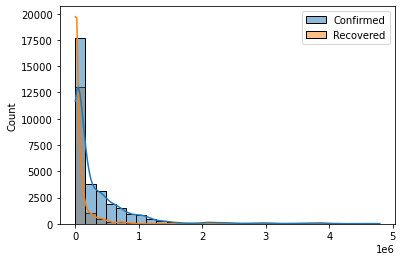

In [33]:
histogram_filter_cases = cases[['Confirmed', 'Recovered']]
sns.histplot(data=histogram_filter_cases, bins=30, kde=True)

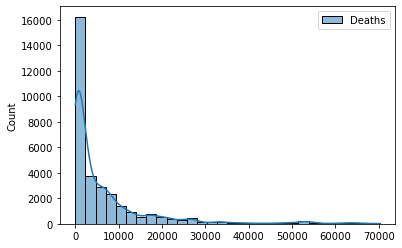

In [34]:
histogram_filter_cases = cases[['Deaths']]
sns.histplot(data=histogram_filter_cases, bins=30, kde=True)

### 4.2 Bar Charts

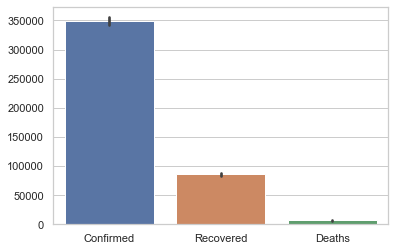

In [35]:
barchart_filter_cases = cases[['Confirmed', 'Recovered','Deaths']]
sns.set_theme(style='whitegrid')
sns.barplot(data=barchart_filter_cases)

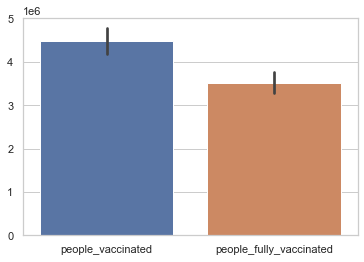

In [36]:
barchart_filter_vacc = vacc[['people_vaccinated', 'people_fully_vaccinated']]
sns.set_theme(style='whitegrid')
sns.barplot(data=barchart_filter_vacc)

### 4.3 Line Plots

#### Getting Time Series Data
Before obtaining Line Plots we first extract the time series data. This is done by
- Grouping by Date
- Aggregating Confirmed, Deaths and Recovered by Sum

In [37]:
# Cumulative Time Series (Add on to previous date's cases)
cum_timeseries = cases.groupby(['Date']).agg(Confirmed = ('Confirmed', 'sum'), Deaths = ('Deaths', 'sum'), Recovered = ('Recovered', 'sum'))

In [38]:
# Delta Time series (Cases on a particular day)
delta_timeseries = cases.groupby(['Date']).agg(Confirmed = ('Confirmed', 'sum'), Deaths = ('Deaths', 'sum'), Recovered = ('Recovered', 'sum')).diff()

#### 4.3.1 Cumulative confirmed cases

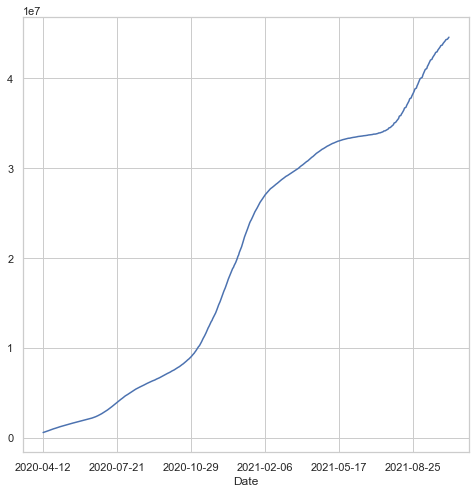

In [43]:
cum_timeseries.Confirmed.plot(figsize=(8, 8))

#### 4.3.2 Daily confirmed cases

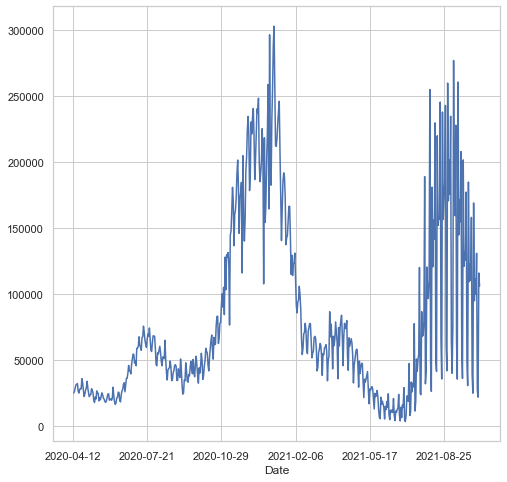

In [44]:
delta_timeseries.Confirmed.plot(figsize=(8, 8))

#### 4.3.3 Cumulative deaths

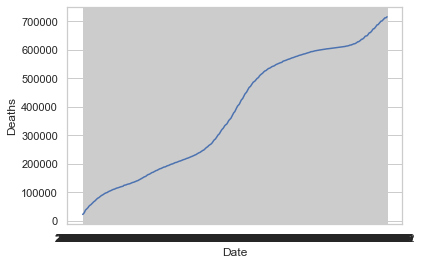

In [41]:
sns.lineplot(data = cum_timeseries, x = "Date", y = "Deaths")

#### 4.3.4 Daily deaths

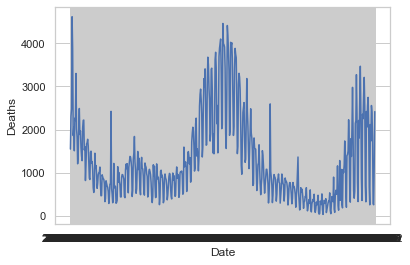

In [42]:
sns.lineplot(data = delta_timeseries, x = "Date", y = "Deaths")

#### 4.3.5 Cumulative recoveries

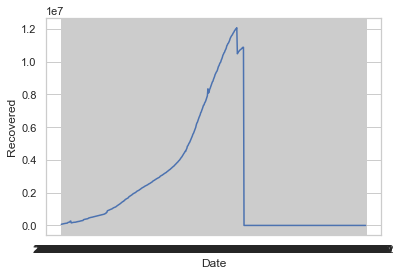

In [47]:
sns.lineplot(data = cum_timeseries, x = "Date", y = "Recovered")

#### 4.3.6 Daily recoveries

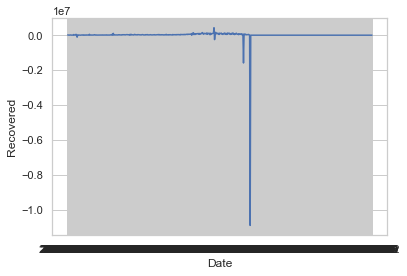

In [48]:
sns.lineplot(data = delta_timeseries, x = "Date", y = "Recovered")

In [49]:
cum_timeseries.to_csv('../cleaned_datasets/usa/cum_cases_usa.csv')
delta_timeseries.to_csv('../cleaned_datasets/usa/daily_cases_usa.csv')

In [50]:
cum_vacc = vacc.groupby(['date']).agg(total_doses = ('total_vaccinations', 'sum'), people_vacc = ('people_vaccinated', 'sum'), people_fully_vacc = ('people_fully_vaccinated', 'sum'), daily_vacc = ('daily_vaccinations', 'sum'))

In [52]:
cum_vacc.to_csv('../cleaned_datasets/usa/vacc_usa.csv')

### 4.4 PCA

***
<a id='Correlation'></a>
## 5. Correlation

- Find the correlation matrix for `cases` and `vacc` to see if any attributes are strongly correlated (we take a threshold of 80%)
- We see if the correlation is meaningful, or indicative of excessive attributes

### 5.1 Correlation for `cases`

In [ ]:
# Correlation matrix
corr_cases = cases.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_cases, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(corr_cases, mask=mask, center=0, square=True, annot=True)

### 5.2 Correlation for `vacc`

In [ ]:
# Correlation matrix
corr_vacc = vacc.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_vacc, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr_vacc, mask=mask, center=0, square=True, annot=True)

***
<a id='Preprocessing'></a>
## 6. Preprocessing

***
<a id='Conclusion'></a>
## 7. Conclusion